# Causal Inference full spec(因果推論フルスペック)
## we can do Causal Inference with this python program

In [116]:
#ＲＥＦＥＲＥＮＣＥ↓（参考にさせていただいた記事）
#https://qiita.com/usaito/items/09daccdd91bc98c21dff

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Reading data and Aggregating(データ読み込み＆集計)

In [2]:
# READING
data_df = pd.read_csv('https://github.com/iwanami-datascience/vol3/raw/master/kato%26hoshino/q_data_x.csv')
data_df.head()

# Cross-tabulation of application usage dummy and CM viewing(アプリ利用ダミーとCM視聴有無のクロス集計)
pd.crosstab(data_df.gamedummy, data_df.cm_dummy)

cm_dummy,0,1
gamedummy,,
0,5428,3832
1,428,312


In [3]:
# Calculate the difference in the number of times the app is used depending on whether you are watching a commercial
#CM視聴有無でのアプリ利用回数の差を計算
data_df[data_df.cm_dummy == 1].gamecount.mean() - data_df[data_df.cm_dummy == 0].gamecount.mean()

-1.4845493913116865

In [4]:
# Calculate the difference in app usage time with and without CM viewing(CM視聴有無でのアプリ利用時間の差を計算)
data_df[data_df.cm_dummy == 1].gamesecond.mean() - data_df[data_df.cm_dummy == 0].gamesecond.mean()

-629.6405765396544

In [5]:
data_df[:10]

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0
5,0,0,0,1,0,0,24.5,0,0,0,...,0,1,0,0,0,0,0,48.417899,0,0
6,0,0,0,0,0,1,19.0,0,0,0,...,1,0,0,0,0,0,0,53.426757,0,0
7,0,0,0,0,1,0,54.5,0,1,1,...,0,0,0,1,0,0,0,56.697458,0,0
8,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,61.996340,0,0
9,0,0,0,1,0,0,34.5,1,0,1,...,0,0,0,0,1,0,0,64.557893,0,0


In [ ]:
import pandas_profiling as pdp
pdp.ProfileReport(data_df)

# Caluculating and Evaluation Propensity Score (傾向スコアの算出＆評価)

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
# 説明変数
cols = ["age", "sex", "TVwatch_day", "marry_dummy", "child_dummy", "inc", "pmoney",
        "area_kanto", "area_tokai", "area_keihanshin",
        "job_dummy1", "job_dummy2", "job_dummy3", "job_dummy4", "job_dummy5", "job_dummy6",
        "fam_str_dummy1", "fam_str_dummy2", "fam_str_dummy3", "fam_str_dummy4"]
X = data_df[cols].copy()

# 切片の導入
X.loc[:, "Intercept"] = 1

# CM視聴有無ダミー
z1 = data_df.cm_dummy

# 目的変数群（1:アプリ利用ダミー, 2:アプリ利用回数、3:アプリ利用時間）
y1 = data_df.gamedummy
y2 = data_df.gamecount
y3 = data_df.gamesecond

#モデルの生成
clf = LogisticRegression(C=10000)
#学習
clf.fit(X,z1)
#モデルに伴う生存率の予測値
ps = clf.predict_proba(X)

In [8]:
import seaborn as sns
sns.distplot(ps[:,1])

In [9]:
from sklearn.metrics import roc_curve
from sklearn import metrics

fpr, tpr, thresholds = roc_curve(z1, ps[:,1])
metrics.auc(fpr, tpr)

#------------------------------------
#0.8以上	効果がすごくいい
#0.7-0.8	効果があります
#0.6-0.7	効果が多少あります
#0.5-0.6	効果がありません
#------------------------------------

0.7836189114685529

# Computing ATE (平均介入効果(ＡＴＥ)の算出)

In [10]:
ps1 =  ps[:,1]

In [11]:
z1a =  np.array(z1)
y1a =  np.array(y1)
y2a =  np.array(y2)
y3a =  np.array(y3)

In [12]:
#傾向スコアを加味せず、単純に効果をひく。
n_ipwe11 = sum((z1a * y1a)) / sum(z1a )  # 介入群＝z1aが１のデータ。
n_ipwe10 = sum(((1 - z1a) * y1a)) / sum((1 - z1a))  # 統制群＝# 介入群＝z1aが0のデータ。
n_ATE1 = n_ipwe11 - n_ipwe10

#介入により、アプリ利用有無に変化があったと言えるか？
# IPWによりアプリ利用ダミーへのATEを推定
ipwe11 = sum((z1a * y1a) / ps1) / sum(z1a / ps1)  # 介入群＝z1aが１のデータ。
ipwe10 = sum(((1 - z1a) * y1a) / (1 - ps1)) / sum((1 - z1a) / (1 - ps1))  # 統制群＝# 介入群＝z1aが0のデータ。
ATE1 = ipwe11 - ipwe10

print(n_ATE1)
print(ATE1)

0.002202143595586223
0.031938505081500326


In [13]:
#傾向スコアを加味せず、単純に効果をひく。
n_ipwe21 = sum((z1a * y2a)) / sum(z1a )  # 介入群＝z1aが１のデータ。
n_ipwe20 = sum(((1 - z1a) * y2a)) / sum((1 - z1a))  # 統制群＝# 介入群＝z1aが0のデータ。
n_ATE2 = n_ipwe21 - n_ipwe20

#介入により、アプリ利用回数に変化があったと言えるか？
# IPWによりアプリ利用ダミーへのATEを推定
ipwe21 = sum((z1a * y2a) / ps1) / sum(z1a / ps1)  # Treated
ipwe20 = sum(((1 - z1a) * y2a) / (1 - ps1)) / sum((1 - z1a) / (1 - ps1))  # Control
ATE2 = ipwe21 - ipwe20

print(n_ATE2)
print(ATE2)

-1.4845493913116865
4.18725183238292


In [14]:
#傾向スコアを加味せず、単純に効果をひく。
n_ipwe31 = sum((z1a * y3a)) / sum(z1a )  # 介入群＝z1aが１のデータ。
n_ipwe30 = sum(((1 - z1a) * y3a)) / sum((1 - z1a))  # 統制群＝# 介入群＝z1aが0のデータ。
n_ATE3 = n_ipwe31 - n_ipwe30

#介入により、アプリ利用時間に変化があったと言えるか？
# IPWによりアプリ利用ダミーへのATEを推定
ipwe31 = sum((z1a * y3a) / ps1) / sum(z1a / ps1)  # Treated
ipwe30 = sum(((1 - z1a) * y3a) / (1 - ps1)) / sum((1 - z1a) / (1 - ps1))  # Control
ATE3 = ipwe31 - ipwe30

print(n_ATE3)
print(ATE3)

-629.6405765396544
934.4221365398948


# UpliftModeling(傾向スコアの補正無し)
### https://qiita.com/0NE_shoT_/items/7b91474430c1f190c470
### https://qiita.com/usaito/items/f713d93732db82696a76

In [17]:
# 説明変数と目的変数を指定
cols = ["child_dummy", "area_kanto", "area_tokai", "area_keihanshin",
        "T", "F1", "F2", "F3", "M1", "M2"]

X = data_df[cols]
y = pd.DataFrame(data_df.gamesecond)

# CMありをtreatment, CMなしをcontrolとする
treat = (data_df.cm_dummy == 1).tolist()

In [42]:
def b_i(boo):
    if boo == True:
       return 1
    else:
       return  0

a = [b_i(boo) for boo in treat ]

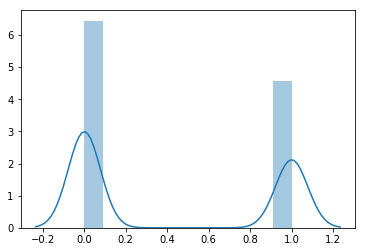

In [43]:
sns.distplot(a)

In [61]:
# train, test半分ずつに分ける
y_train, y_test, train_treat, test_treat, X_train, X_test = train_test_split(y.values, treat, X, test_size=0.5, random_state=2)

# indexをリセット
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Separate Model Approach
# 学習用に用いるデータを生成
num = len(y_train)
treat_y = np.reshape(np.array([y_train[i] for i in range(num) if train_treat[i] is True]), -1)
control_y = np.reshape(np.array([y_train[i] for i in range(num) if train_treat[i] is False]), -1)
treat_X = pd.DataFrame([X_train.loc[i] for i in range(num) if train_treat[i] is True])
control_X = pd.DataFrame([X_train.loc[i] for i in range(num) if train_treat[i] is False])

In [62]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor

# ランダムフォレスト回帰を用いる
params_rf = {"max_depth": [10, 50, 100]}
gs_rf_treat = GridSearchCV(RandomForestRegressor(n_estimators=500),
                           param_grid=params_rf, cv=5)
gs_rf_control = GridSearchCV(RandomForestRegressor(n_estimators=500),
                             param_grid=params_rf, cv=5)

# 介入群と非介入群それぞれでパラメータチューニング及びスマホアプリ利用時間を予測するモデルを構築
gs_rf_treat.fit(treat_X, treat_y)
gs_rf_control.fit(control_X, control_y)

# uplift-scoreの算出
# CMを見た場合のアプリ利用時間
pred_treat = gs_rf_treat.predict(X_test)

# CMを見なかった場合のアプリ利用時間
pred_control = gs_rf_control.predict(X_test)

# 今回は、(CMを見た場合のアプリ利用時間) - (CMを見なかった場合のアプリ利用時間) をuplift_scoreとする。
uplift_score = pred_treat - pred_control

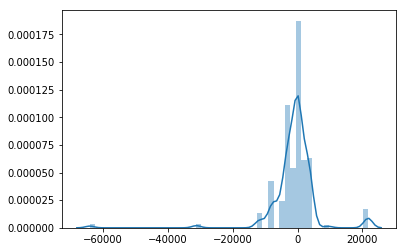

In [64]:
sns.distplot(uplift_score)

In [ ]:
#pd.concat([df1, df2])

In [99]:
y_test_df =  pd.DataFrame(data=y_test)
test_treat_df = pd.DataFrame(data=test_treat)
uplift_score_df = pd.DataFrame(data=uplift_score)

In [103]:
result = pd.concat([y_test_df, test_treat_df,uplift_score_df],axis=1)

In [105]:
result.columns = ['cv_flg', 'treat_flg', 'uplift_score']

In [107]:
result.loc[result['treat_flg']== True, 'treat_flg'] = 1
result.loc[result['treat_flg']== False, 'treat_flg'] = 0

In [108]:
result[:5]

,cv_flg,treat_flg,uplift_score
0,0,1,-7554.605833
1,0,0,70.426762
2,0,0,-3724.965115
3,0,0,-2931.596362
4,0,0,3790.316774


In [111]:
result

,cv_flg,treat_flg,uplift_score,treat_num_cumsum,control_num_cumsum,treat_cv_cumsum,control_cv_cumsum
0,0,0,21760.615164,0,1,0,0
1,0,0,21760.615164,0,2,0,0
2,0,0,21760.615164,0,3,0,0
3,0,0,21760.615164,0,4,0,0
4,0,0,21760.615164,0,5,0,0
...,...,...,...,...,...,...,...
4995,0,1,-64039.282844,2052,2944,5432175,9223314
4996,0,1,-64039.282844,2053,2944,5432175,9223314
4997,97226,0,-64039.282844,2053,2945,5432175,9320540
4998,0,1,-64039.282844,2054,2945,5432175,9320540


In [117]:
# uplift score が大きい順に検証データを並び替え
result = result.sort_values(by='uplift_score', ascending=False).reset_index(drop=True)

# lift の算出
result['treat_num_cumsum'] = result['treat_flg'].cumsum()
result['control_num_cumsum'] = (1 - result['treat_flg']).cumsum()
result['treat_cv_cumsum'] = (result['treat_flg'] * result['cv_flg']).cumsum()
result['control_cv_cumsum'] = ((1 - result['treat_flg']) * result['cv_flg']).cumsum()
result['treat_cvr'] = (result['treat_cv_cumsum'] / (result['treat_num_cumsum']+0.001)).fillna(0)
result['control_cvr'] = (result['control_cv_cumsum'] / (result['control_num_cumsum']+0.001)).fillna(0)
result['lift'] = (result['treat_cvr'] - result['control_cvr']) * result['treat_num_cumsum']
result['base_line'] = result.index * result['lift'][len(result.index) - 1] / len(result.index)

# AUUC の算出
auuc = (result['lift'] - result['base_line']).sum() / len(result['lift'])
print('AUUC = {:.2f}'.format(auuc))
# 出力：=> AUUC = 37.70

AUUC = 2235867.05


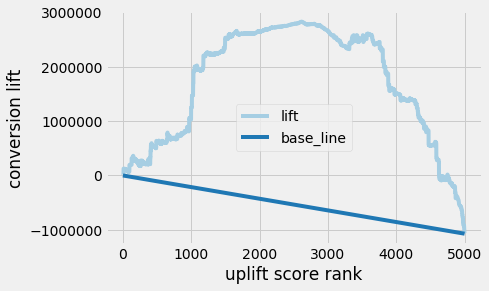

In [118]:
import matplotlib.pyplot as plt
result.plot(y=['lift', 'base_line'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion lift')
plt.show()

In [119]:
from sklearn.linear_model import LinearRegression

### 正則化項なしの線形回帰
lr = LinearRegression()
lr.fit(X_test, uplift_score)
for feature, coef in zip(X_train.columns, lr.coef_):
    print(f"{feature} / {round(coef, 4)}")

child_dummy / -2741.7337
area_kanto / -4112.5285
area_tokai / -4095.1288
area_keihanshin / 2997.0794
T / 6021.0708
F1 / 461.2852
F2 / 798.4251
F3 / 1486.685
M1 / -6875.9041
M2 / 5183.7698


# UpliftModeling(傾向スコアの補正あり)

In [125]:
# データの読み込み
data_df = pd.read_csv('https://github.com/iwanami-datascience/vol3/raw/master/kato%26hoshino/q_data_x.csv')
data_df.head()

# 傾向スコアを求める
# 説明変数
cols_ = ["age", "sex", "TVwatch_day", "marry_dummy", "child_dummy", "inc", "pmoney",
         "area_kanto", "area_tokai", "area_keihanshin",
         "job_dummy1", "job_dummy2", "job_dummy3", "job_dummy4", "job_dummy5", "job_dummy6",
         "fam_str_dummy1", "fam_str_dummy2", "fam_str_dummy3", "fam_str_dummy4"]

X_ = data_df[cols_].copy()

# 切片の導入
X_.loc[:, "Intercept"] = 1

# CM視聴有無ダミー
z1 = data_df.cm_dummy

from sklearn.linear_model import LogisticRegression
#モデルの生成
clf = LogisticRegression(C=10000)
#学習
clf.fit(X_,z1)
#モデルに伴う生存率の予測値
ps = clf.predict_proba(X_)

#整形
ps = pd.DataFrame(ps[:,1])

In [154]:
# Propensity Scoreで補正された目的変数のカラムを作成
data_df["ps"] = ps
data_df.loc[:, "adj_gamesecond"] = 0
data_df.loc[data_df.cm_dummy == 1, "adj_gamesecond"] = data_df.loc[data_df.cm_dummy == 1, "gamesecond"] / data_df.loc[data_df.cm_dummy == 1, "ps"]
data_df.loc[data_df.cm_dummy == 0, "adj_gamesecond"] = -data_df.loc[data_df.cm_dummy == 0, "gamesecond"] / (1 - data_df.loc[data_df.cm_dummy == 0, "ps"])
adj_y = data_df[["gamesecond", "adj_gamesecond"]]

In [160]:
adj_y

,gamesecond,adj_gamesecond
0,0,0.000000
1,0,0.000000
2,0,0.000000
3,0,0.000000
4,0,0.000000
...,...,...
9995,97226,-118964.034778
9996,97224,-118965.711129
9997,97227,-118968.091639
9998,97225,-118965.487092


In [156]:
# CMありをtreatment, CMなしをcontrolとする
treat = (data_df.cm_dummy == 1).tolist()

# train, test半分ずつに分ける
adj_y_train, adj_y_test, train_treat, test_treat, X_train, X_test = train_test_split(adj_y, treat, X, test_size=0.5, random_state=2)

# indexをリセット
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
adj_y_train = adj_y_train.reset_index(drop=True)
adj_y_test = adj_y_test.reset_index(drop=True)

In [157]:
# ランダムフォレスト回帰を用いる
params_rf = {"max_depth": [10, 50, 100]}
gs_rf = GridSearchCV(RandomForestRegressor(n_estimators=500), param_grid=params_rf, cv=5)

# パラメータチューニング及び補正スマホアプリ利用時間を予測するモデルを構築
gs_rf.fit(X_train, adj_y_train.adj_gamesecond)

# 補正uplift_scoreを求める
adj_uplift_score = gs_rf.predict(X_test)

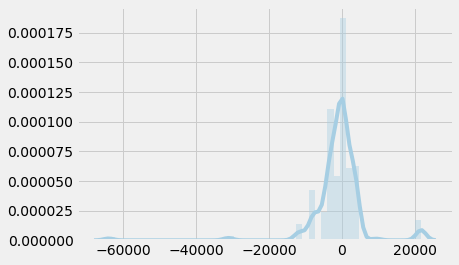

In [159]:
sns.distplot(uplift_score)

In [162]:
adj_y_test_df =  pd.DataFrame(data=adj_y_train.adj_gamesecond)
test_treat_df = pd.DataFrame(data=test_treat)
adj_uplift_score_df = pd.DataFrame(data=adj_uplift_score)

In [165]:
adj_result = pd.concat([adj_y_test_df, test_treat_df,adj_uplift_score_df],axis=1)

In [166]:
adj_result.columns = ['cv_flg', 'treat_flg', 'uplift_score']
adj_result.loc[result['treat_flg']== True, 'treat_flg'] = 1
adj_result.loc[result['treat_flg']== False, 'treat_flg'] = 0
adj_result[:5]

,cv_flg,treat_flg,uplift_score
0,0.0,0,-3525.642353
1,0.0,0,35.252147
2,0.0,0,-2311.330563
3,0.0,0,-3217.164775
4,0.0,0,7569.139191


In [168]:
# uplift score が大きい順に検証データを並び替え
adj_result = adj_result.sort_values(by='uplift_score', ascending=False).reset_index(drop=True)

# lift の算出
adj_result['treat_num_cumsum'] = adj_result['treat_flg'].cumsum()
adj_result['control_num_cumsum'] = (1 - adj_result['treat_flg']).cumsum()
adj_result['treat_cv_cumsum'] = (adj_result['treat_flg'] * adj_result['cv_flg']).cumsum()
adj_result['control_cv_cumsum'] = ((1 - adj_result['treat_flg']) * adj_result['cv_flg']).cumsum()
adj_result['treat_cvr'] = (adj_result['treat_cv_cumsum'] / (adj_result['treat_num_cumsum']+0.1)).fillna(0)
adj_result['control_cvr'] = (adj_result['control_cv_cumsum'] / (adj_result['control_num_cumsum']+0.1)).fillna(0)
adj_result['lift'] = (adj_result['treat_cvr'] - adj_result['control_cvr']) * adj_result['treat_num_cumsum']
adj_result['base_line'] = adj_result.index * adj_result['lift'][len(adj_result.index) - 1] / len(adj_result.index)

# AUUC の算出
adj_auuc = (adj_result['lift'] - adj_result['base_line']).sum() / len(adj_result['lift'])
print('AUUC = {:.2f}'.format(adj_auuc))
# 出力：=> AUUC = 37.70

AUUC = -578206.46


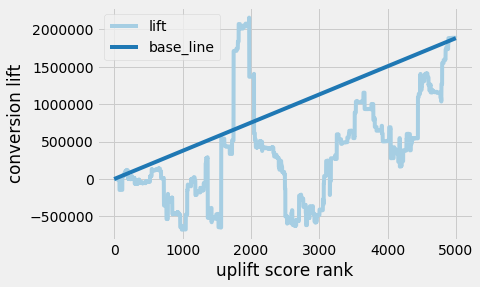

In [169]:
import matplotlib.pyplot as plt
adj_result.plot(y=['lift', 'base_line'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion lift')
plt.show()